In [1]:
#Assignment 4 Question 1 

In [2]:
#all necessary packages :) 
import numpy as np
import camb
from matplotlib import pyplot as plt
import time

# #importing the data! 
# bindata = np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt')
# #oops, wrong file. This is the right one!/ 
# rawdata = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt')


chisq is  15267.937968222595  for  2501  degrees of freedom.


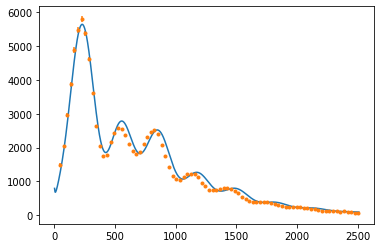

In [3]:
#This is the code Prof. Sievers wrote! 
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()


Based on the chi-squared value, are the parameters used in the above plot an acceptable fit? 

This seems pretty dang high. Although, according to the internet, the p value for this chi-squared is much lower than most acceptance values, so I guess it's good enough? I'm not sure what passes for a good chi squared in this scenario. Plus, the model doesn't really fit the front tail of this spectrum. 

chisq with new parameters is  3272.2033778089576  for  2501  degrees of freedom.


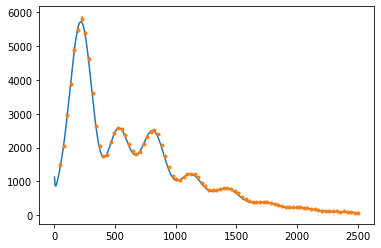

In [4]:
#Trying again with different parameters! 

#defining the new parameters
pars2=np.asarray([69,0.022,0.12,0.06,2.10e-9,0.95])
model2=get_spectrum(pars2)
model2=model2[:len(spec)]
resid2=spec-model2
chisq2=np.sum( (resid2/errs)**2)
print("chisq with new parameters is ",chisq2," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model2)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()


 This one is like 5 times smaller than the other one! Clearly, being closer to the 'actual' values can reduce the chi squared dramatically. Even based on visual inspection, this model looks much much better. 

In [5]:
#Assignment 4 Question 2 
#Writing a code for Newton's Method! 

#stealing/adapting the code I wrote for my thesis: 

#step 1: Something that takes the derivative of some function I give 
    #this is presumably the spectrum function he gives above ... not sure how I'll take 
    #the derivative of that ... 
#step 2: Something that evaluates dx depending on the previous iteration of the function 
#step 3: Newton's method, like below, except it takes like 7 parameters instead of 1 


def deriv(x,func,par,dx):
    derivs = np.zeros([len(x),len(par)])

    for i in range(len(par)):
        par_d = par.copy()
        par_d = par[i]*dx #making a small variance 
        par[i] = par[i] + par_d #adding this small variance

        spec_dx = func(par)[2:len(x)+2] #removing first two points 

        #next direction 
        par[i] = par[i] - 2*par_d
        spec_dx_2 = func(par)[2:len(x)+2]
        derivative = (spec_dx - spec_dx_2)/(2*par_d)
        derivs[:,i] = np.asarray(derivative)
    return derivs



In [6]:
#number of iterations I'm ok with this thing doing: 
iterations = 50


def newton(x,func,par,err):
    first_chi = 7000 
    d = deriv(x,func,par,0.001)
    lamb = 0.0001
    first_par = par.copy()

    for j in range(iterations):
        guess = func(first_par,lmax=3000)[2:len(x)+2]
        res = x - guess
        next_chi = (res**2/err**2).sum()
        diff = first_chi - next_chi
        if diff < 0.001 and diff > 0:
            print('final chi squared:',next_chi)
            par = first_par.copy()
            d = deriv(x,func,par,0.001)
            N = np.diag(1/err**2)
            A = np.dot(d.transpose(),N)
            A = np.dot(A,d)
            A = np.linalg.inv(A)
            error = np.sqrt(np.diag(A))
            break
        elif next_chi > first_chi:
            print('chi squared grew')
            lamb = 100*lamb
            first_par = par.copy()

        else: 
            par = first_par.copy()
            first_chi = next_chi
            d = deriv(x,func,par,0.001)
            lamb = lamb/70
        residual = np.matrix(res).transpose()
        d = np.matrix(d)
        left = d.transpose()*np.diag(1/err**2)*d
        left_hs = left + lamb*np.diag(left)
        right_hs = d.transpose()*np.diag(1/err**2)*residual
        new = np.linalg.inv(left_hs)*(right_hs)
        for k in range(len(par)):
            first_par[k] = first_par[k] + new[k]
        print ("we are currently on iteration:",j)
        print('the chi squared value is',first_chi)
    return par, A, error

In [7]:
p, cov, err = newton(spec,get_spectrum,pars2,errs)
np.savetxt('planck_fit_params.txt',(p,err))

we are currently on iteration: 0
the chi squared value is 3518.1547677431054
we are currently on iteration: 1
the chi squared value is 2600.832785933144
we are currently on iteration: 2
the chi squared value is 2590.2489291159163
we are currently on iteration: 3
the chi squared value is 2589.2685545571726
we are currently on iteration: 4
the chi squared value is 2589.0144047265867
we are currently on iteration: 5
the chi squared value is 2586.3605586324884
we are currently on iteration: 6
the chi squared value is 2585.5990086245156
we are currently on iteration: 7
the chi squared value is 2585.5959371424347
chi squared grew
we are currently on iteration: 8
the chi squared value is 2585.5959371424347
chi squared grew
we are currently on iteration: 9
the chi squared value is 2585.5959371424347
chi squared grew
we are currently on iteration: 10
the chi squared value is 2585.5959371424347
chi squared grew
we are currently on iteration: 11
the chi squared value is 2585.5959371424347
we are 

In [41]:
#Assignment 3 Question 3 - MCMC built from SCRATCH!! dun dun dun 

#we need something that will calculate the chi squared of a result 
#depending on this value it will either take a step or it won't 

#how to draw trial steps from a covariance matrix ?? 
#apparently cholesky decomposition 'allows you to simulate 
#uncorrelated normal variables and transform them into 
#correlated normal variables'

def mcmc(x,func,par,err,steps,cov):
    num = 0 
    params = np.zeros([steps,len(par)])
    chis = np.zeros(steps)
    residual = x - func(par)[2:len(x)+2]
    chi = np.sum(residual**2/err**2)
    print('first chi',chi)
    for i in range(steps):
        print(i)
        L = np.linalg.cholesky(cov)
        pcov = np.dot(L,np.random.randn(cov.shape[0]))
        new_pos = par + pcov*0.5
        if new_pos[3] > 0:
            new_val = func(new_pos)[2:len(x)+2]
            new_residual =  x - new_val
            new_chi = np.sum(new_residual**2/err**2)
            print('new chi',new_chi)
            diff = new_chi - chi
            prob = np.exp(-0.5*diff)
            accept = np.random.rand(1)<prob
            if accept:
                num+=1
                par = new_pos
                val = new_val
                chi = new_chi
        params[i,:] = par
        chis[i] = chi
    return params, chis, par



In [56]:
params, chis, par = mcmc(spec,get_spectrum,pars2,errs,1000,cov)



first chi 3518.1547677431054
0
new chi 3505.7064902015954
1
new chi 3552.0102609160194
2
new chi 3527.072845827278
3
new chi 3543.4680875219287
4
new chi 3470.998351086888
5
new chi 3520.3430382535607
6
new chi 3462.7660643221047
7
new chi 3519.5958433452997
8
new chi 3557.699789916409
9
new chi 3557.3028669631403
10
new chi 3408.809588519118
11
new chi 3383.525085098047
12
new chi 3406.7961079929
13
new chi 3411.762461088914
14
new chi 3397.2835343749284
15
new chi 3588.616752800334
16
new chi 3405.362216350613
17
new chi 3407.1445404567253
18
new chi 3388.0771169944655
19
new chi 3366.6830608081104
20
new chi 3400.1944439230474
21
new chi 3416.872191018727
22
new chi 3417.8860465903567
23
new chi 3375.4212956739243
24
new chi 3411.8989114184233
25
new chi 3420.313051700347
26
new chi 3399.1313422222393
27
new chi 3395.6249704393
28
new chi 3356.5992576521166
29
new chi 3338.4472881325373
30
new chi 3368.719271797337
31
new chi 3359.5439410431645
32
new chi 3313.967702674932
33
new ch

new chi 2598.6412928361997
272
new chi 2605.9596383647818
273
new chi 2601.2297586915765
274
new chi 2601.3774593626968
275
new chi 2597.867831864706
276
new chi 2599.2305319167094
277
new chi 2594.486382116437
278
new chi 2593.0907548931464
279
new chi 2596.4117208123953
280
new chi 2606.871291356454
281
new chi 2598.875630739103
282
new chi 2600.4647954980164
283
new chi 2594.1470564427814
284
new chi 2605.096675187894
285
new chi 2601.2723363386594
286
new chi 2603.2409126860857
287
new chi 2591.933765782447
288
new chi 2593.580794895908
289
new chi 2594.0051635633376
290
new chi 2610.1275290924314
291
new chi 2595.7951353944263
292
new chi 2609.1564849516544
293
new chi 2591.797568195302
294
new chi 2593.238844270196
295
new chi 2590.4916379265514
296
new chi 2594.433937086257
297
new chi 2589.542172935957
298
new chi 2592.4266418582083
299
new chi 2594.8442106456578
300
new chi 2590.302174328056
301
new chi 2595.215235643055
302
new chi 2594.560816666907
303
new chi 2593.209601412

new chi 2599.728744235238
541
new chi 2605.0936896270077
542
new chi 2604.9083370593194
543
new chi 2599.435363693012
544
new chi 2593.8372610071638
545
new chi 2603.2643400631573
546
new chi 2598.025955787859
547
new chi 2594.1732014604977
548
new chi 2593.5374941724403
549
new chi 2590.602031289378
550
new chi 2593.8783173573083
551
new chi 2588.442832974361
552
new chi 2598.080293244555
553
new chi 2594.706180067795
554
new chi 2591.4956238448035
555
new chi 2591.9857154083056
556
new chi 2594.4421354565475
557
new chi 2589.7142250812963
558
new chi 2587.454879015274
559
new chi 2590.212586978548
560
new chi 2587.3337862533963
561
new chi 2591.1834563307248
562
new chi 2590.6453174848525
563
new chi 2587.817017906148
564
new chi 2589.9612707642245
565
new chi 2588.9849291680903
566
new chi 2593.933181651573
567
new chi 2596.2944392213144
568
new chi 2592.060623006702
569
new chi 2593.466476030448
570
new chi 2589.580045084334
571
new chi 2588.34773574845
572
new chi 2590.12205979272

new chi 2586.26082437299
810
new chi 2587.453328502281
811
new chi 2589.1353547105846
812
new chi 2591.149144533684
813
new chi 2590.1844824755863
814
new chi 2588.1177206458324
815
new chi 2588.76319400996
816
new chi 2588.0076970177015
817
new chi 2587.041285421221
818
new chi 2586.7135256905585
819
new chi 2588.7928653583226
820
new chi 2588.890822309103
821
new chi 2588.7050836393923
822
new chi 2590.6942388403736
823
new chi 2586.5612585441822
824
new chi 2588.2659498210805
825
new chi 2587.7516800612684
826
new chi 2611.063857877323
827
new chi 2588.3123375345876
828
new chi 2590.2639476678496
829
new chi 2587.90823129101
830
new chi 2587.0224753646635
831
new chi 2586.2123197798946
832
new chi 2585.973555009409
833
new chi 2586.8389615312153
834
new chi 2590.7688404233254
835
new chi 2585.9148837675966
836
new chi 2588.178638959456
837
new chi 2589.0984852865176
838
new chi 2589.4955170320522
839
new chi 2593.5210489245346
840
new chi 2595.9673304925846
841
new chi 2594.35298445

In [99]:
np.savetxt('planck_chain_chis.txt',chis)
np.savetxt('planck_chain.txt',params)
#I'm sorry, I couldn't figure out how to save them to the same file 
#Embarassing 

In this plot we can see that the burn-in time is probably around 200-300 steps!
The average chi squared value after burn-in is 2590.8637715662917 


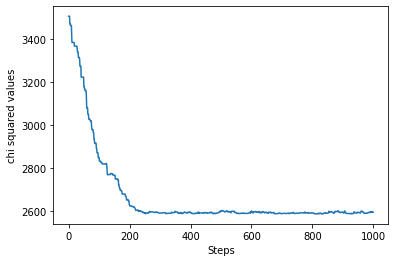

In [89]:
plt.plot(chis)
plt.ylabel('chi squared values')
plt.xlabel('Steps')
print('In this plot we can see that the burn-in time is probably around 200-300 steps!')
print(f'The average chi squared value after burn-in is {np.mean(chis[700:])} ')

In [72]:
Ho = np.mean(np.transpose(params)[0])
Obh2 =  np.mean(np.transpose(params)[1])
Och2 =  np.mean(np.transpose(params)[2])
tau = np.mean(np.transpose(params)[3])
As =  np.mean(np.transpose(params)[4])
ns = np.mean(np.transpose(params)[5])

h = Ho/100

Ob = Obh2/(h**2)
Oc = Och2/(h**2)
Oa = 1 - Ob - Oc

# error propagation: 

h_err = np.std(np.transpose(params)[0])/100
Obh2_err =  np.std(np.transpose(params)[1])
Och2_err =  np.std(np.transpose(params)[2])

Ob_err = Ob*np.sqrt((Obh2_err/Obh2)**2 + (h_err/h)**2)
Oc_err = Oc*np.sqrt((Och2_err/Obh2)**2 + (h_err/h)**2)
Oa_err = np.sqrt(Ob_err**2 + Oc_err**2)


print(f'according to mcmc retrievals, the mean value of dark energy is {Oa} with an uncertainty of {Oa_err}  ')

according to mcmc retrievals, the mean value of dark energy is 0.699474303147629 with an uncertainty of 0.03387716261854228  


Text(0, 0.5, 'Primordial tilt ($n_{s}$)')

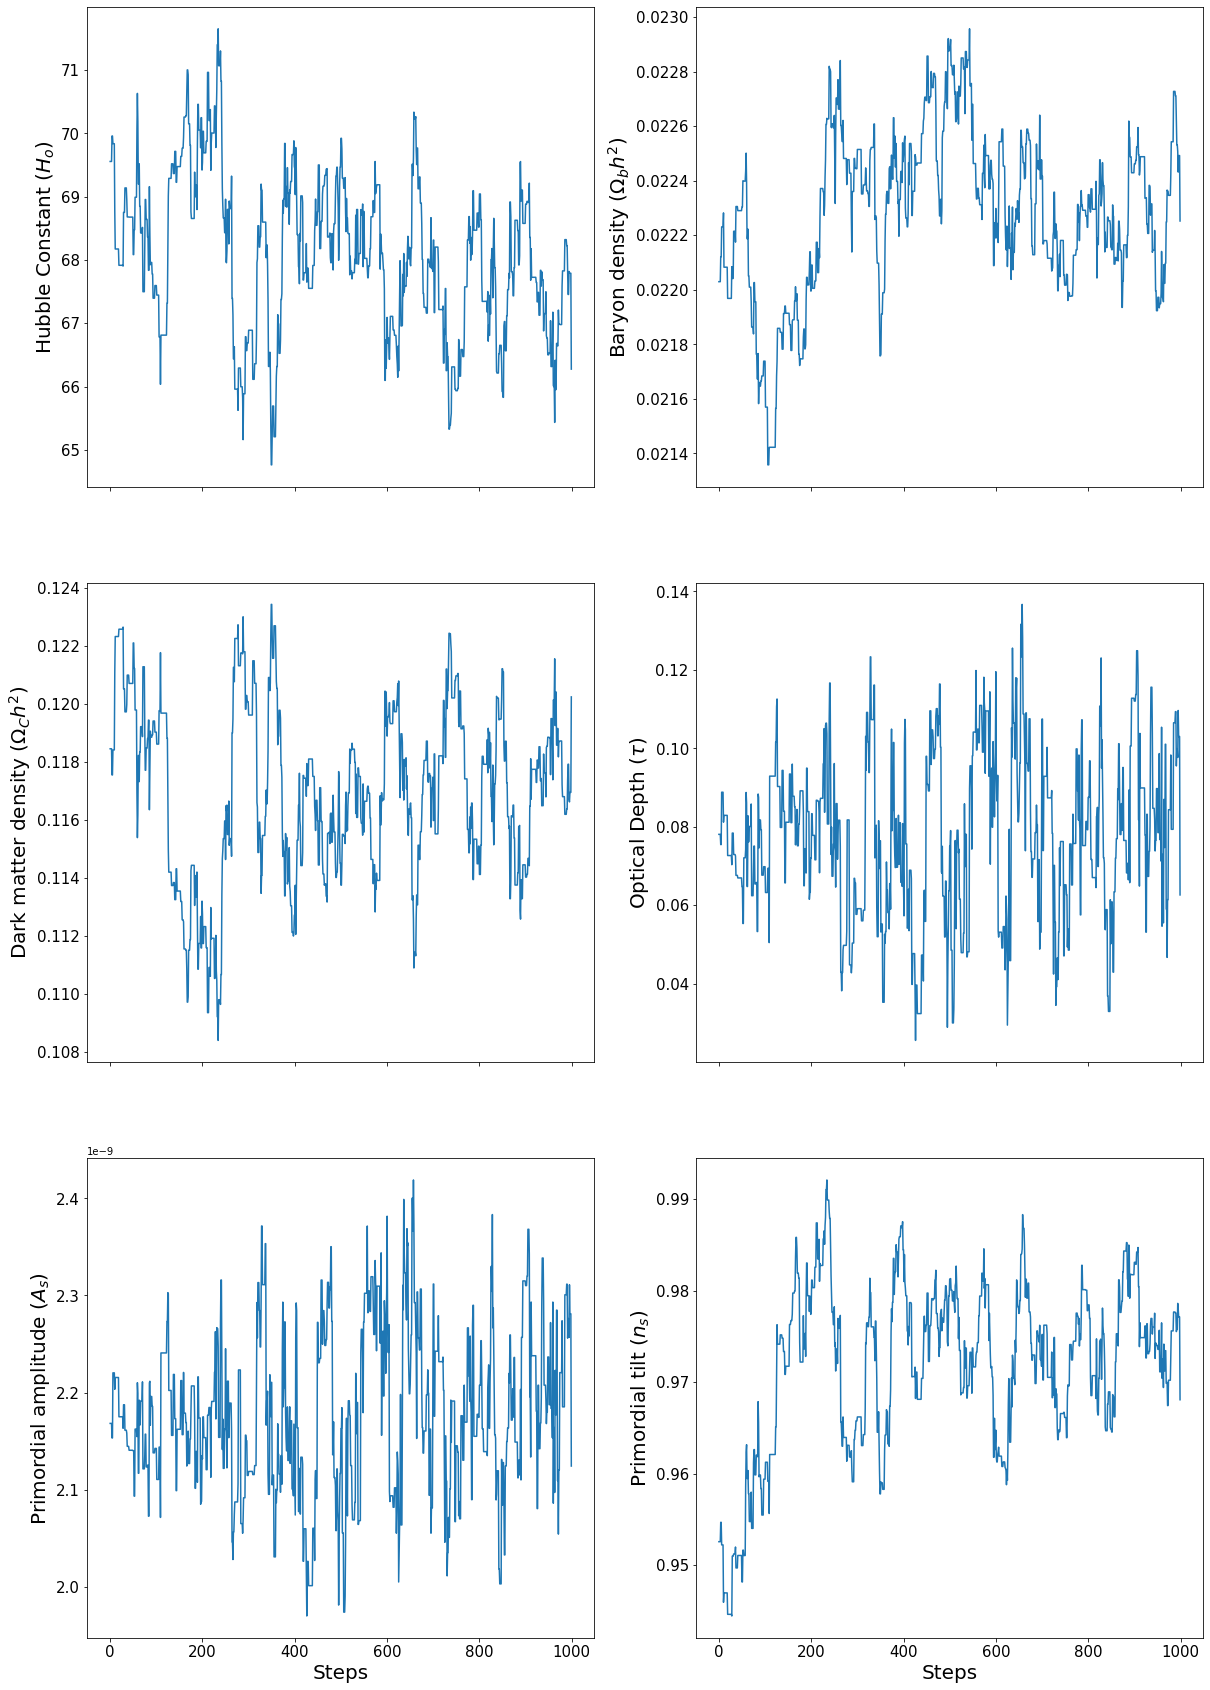

In [87]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,30),sharex=True)

ax1.plot(np.abs(np.transpose(params)[0]))
ax1.tick_params(labelsize=15)
ax1.set_ylabel(r'Hubble Constant ($H_{o}$)',fontsize=20)

ax2.plot(np.transpose(params)[1])
ax2.tick_params(labelsize=15)
ax2.set_ylabel(r'Baryon density ($\Omega_{b}h^{2}$)',fontsize=20)

ax3.plot(np.transpose(params)[2])
ax3.tick_params(labelsize=15)
ax3.set_ylabel(r'Dark matter density ($\Omega_{C}h^{2}$)',fontsize=20)

ax4.plot(np.transpose(params)[3])
ax4.tick_params(labelsize=15)
ax4.set_ylabel(r'Optical Depth ($\tau$)',fontsize=20)

ax5.plot(np.transpose(params)[4])
ax5.tick_params(labelsize=15)
ax5.set_xlabel('Steps',fontsize=20)
ax5.set_ylabel(r'Primordial amplitude ($A_{s}$)',fontsize=20)

ax6.plot(np.transpose(params)[5])
ax6.tick_params(labelsize=15)
ax6.set_xlabel('Steps',fontsize=20)
ax6.set_ylabel(r'Primordial tilt ($n_{s}$)',fontsize=20)

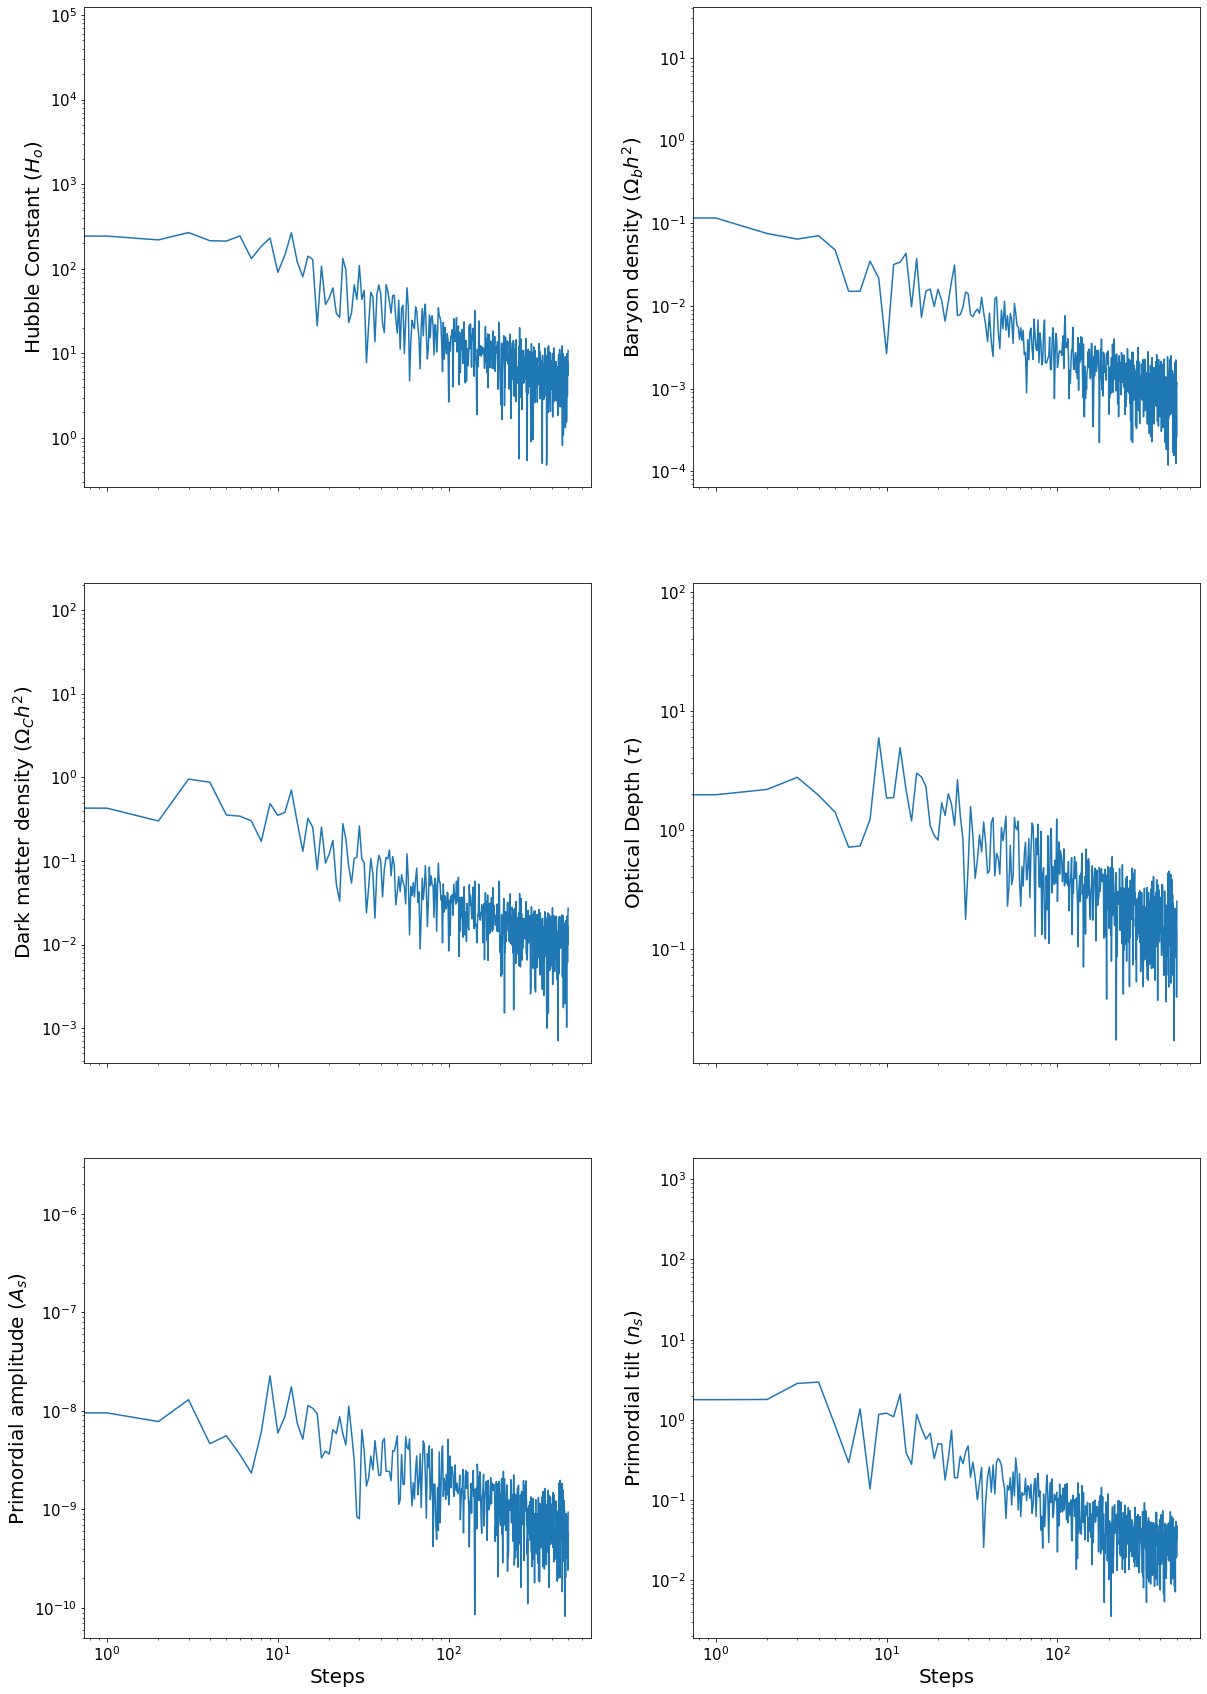

In [86]:
#checking if all my steps converged! 

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,30),sharex=True)


ax1.plot(np.abs(np.fft.rfft(np.transpose(params)[0])))
ax1.tick_params(labelsize=15)
ax1.set_ylabel(r'Hubble Constant ($H_{o}$)',fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')


ax2.plot(np.abs(np.fft.rfft(np.transpose(params)[1])))
ax2.tick_params(labelsize=15)
ax2.set_ylabel(r'Baryon density ($\Omega_{b}h^{2}$)',fontsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')

ax3.plot(np.abs(np.fft.rfft(np.transpose(params)[2])))
ax3.tick_params(labelsize=15)
ax3.set_ylabel(r'Dark matter density ($\Omega_{C}h^{2}$)',fontsize=20)
ax3.set_yscale('log')
ax3.set_xscale('log')

ax4.plot(np.abs(np.fft.rfft(np.transpose(params)[3])))
ax4.tick_params(labelsize=15)
ax4.set_ylabel(r'Optical Depth ($\tau$)',fontsize=20)
ax4.set_yscale('log')
ax4.set_xscale('log')


ax5.plot(np.abs(np.fft.rfft(np.transpose(params)[4])))
ax5.tick_params(labelsize=15)
ax5.set_ylabel(r'Primordial amplitude ($A_{s}$)',fontsize=20)
ax5.set_yscale('log')
ax5.set_xscale('log')


ax6.plot(np.abs(np.fft.rfft(np.transpose(params)[5])))
ax6.tick_params(labelsize=15)
ax6.set_ylabel(r'Primordial tilt ($n_{s}$)',fontsize=20)
ax6.set_yscale('log')
ax6.set_xscale('log')



Based om the plots included above, I'd say the chains all end up converging! That's great :) 

In [52]:
#Assignment 3 Question 4 

#adding a prior on tau - what does this mean?
#how do we include this constraint? 
#what does it mean to re-estimate the parameter covariance matrix 
#(possibly via importance sampling????)

#I'll copy and edit my old mcmc equation ... 
#this one already has the constraint that tau has to be positive ... 
def mcmc_new(x,func,par,err,steps,cov,rtau,errtau):
    num = 0 
    params = np.zeros([steps,len(par)])
    chis = np.zeros(steps)
    residual = x - func(par)[2:len(x)+2]
    chi = (residual**2/err**2).sum()
    first_pos = par.copy()
    for i in range(steps):
        print(i)
        L = np.linalg.cholesky(cov)
        pcov = np.dot(L,np.random.randn(cov.shape[0]))
        new_pos = par + pcov*0.5
        #adding the known error on tau as a 'prior' 
        #doubled error to give them a bit more 'room'
        if new_pos[3] > rtau - 2*errtau and new_pos[3] < rtau + 2*errtau:
            new_val = func(new_pos)[2:len(x)+2]
            new_residual =  x - new_val
            new_chi = (new_residual**2/err**2).sum()
            print(new_chi)
            diff = new_chi - chi
            prob = np.exp(-0.5*diff)
            accept = np.random.rand(1)<prob
            if accept:
                num+=1
                par = new_pos
                val = new_val
                chi = new_chi
        params[i,:] = par
        chis[i] = chi
    return params, chis, par
        

In [53]:
rtau = 0.0540 
errtau = 0.0074

In [55]:
new_params, new_chis, new_par = mcmc_new(spec,get_spectrum,pars2,errs,5000,cov,rtau,errtau)


0
3470.9846123480465
1
2
3
4
5
3527.587263890311
6
7
3484.4947449557585
8
9
3491.177256847316
10
11
3433.2422341266715
12
13
3443.598774643312
14
3445.8020674480103
15
3507.23454939917
16
17
3457.662586013141
18
3481.050065271211
19
3428.7972786308983
20
21
3424.3888345125283
22
23
3483.2000187002986
24
3401.659017836516
25
3398.3919286056725
26
27
3370.1595967366707
28
29
30
3358.798039327311
31
32
3285.4300085145055
33
3297.2850862183323
34
35
36
3241.3992880479323
37
38
39
3278.853816443187
40
41
42
43
3319.850539606978
44
45
3271.61264762202
46
47
3248.990176334143
48
3237.219575642488
49
50
3232.4657097720838
51
3224.351288588109
52
3239.0316653438335
53
54
3216.6416721955798
55
56
3210.4023626079615
57
58
3228.6514542972054
59
3223.5923879618613
60
3155.6106189189954
61
3176.9072010987898
62
3147.523015503587
63
64
65
3117.650657722238
66
3097.636299990487
67
68
69
3144.3925429857018
70
71
72
73
3145.4023413612094
74
75
3134.2312021144826
76
3082.0176475103813
77
78
3101.75233267

2592.400750334849
592
593
594
595
2595.035447400168
596
597
598
2596.469828225665
599
2598.55439283717
600
2596.681990253518
601
602
2599.076228406403
603
2594.2290602374746
604
2594.830196287867
605
2590.133053304424
606
2591.872985321955
607
2589.4718545129726
608
2589.963798064987
609
2590.018736932986
610
2592.1055539832078
611
612
613
2591.991806396024
614
615
2595.252562708931
616
2592.2288444065043
617
2591.1075848867995
618
619
2594.9186125075867
620
2594.254754047106
621
622
2589.6017115998516
623
2588.9938885048196
624
625
626
627
2591.9406521625087
628
2588.754691505288
629
2589.2945296783582
630
2594.519642758799
631
632
2593.7634673775046
633
2591.9443192954886
634
635
2591.561471557513
636
2592.7736960642997
637
2594.8846704991324
638
639
640
641
2589.800585828203
642
2588.5080569157813
643
644
2590.720586119805
645
646
647
648
2589.47796977308
649
650
651
2589.8039953727553
652
653
2589.6783182175755
654
2589.750850940123
655
2592.179879528698
656
2592.841000015954
657
6

2590.714437114477
1163
1164
2590.217816005352
1165
2591.5651048620775
1166
1167
2590.9611128880188
1168
2591.3767347731737
1169
2592.162056900969
1170
2599.463964549137
1171
1172
1173
2597.0786586260024
1174
2592.1774713062678
1175
2589.6536598907505
1176
2588.30928814375
1177
1178
1179
1180
2592.1407812343705
1181
2587.6711657684727
1182
1183
2588.030407044554
1184
2593.6459974407844
1185
2597.019115824857
1186
1187
2595.3851654477194
1188
1189
2592.8694815730487
1190
1191
1192
2598.279905719238
1193
1194
1195
2597.3247126740653
1196
1197
1198
1199
2593.9136034953517
1200
2597.07164880022
1201
2598.6850085265833
1202
2596.234141444751
1203
1204
2600.7142502285183
1205
2594.9761738862153
1206
2596.3336498268955
1207
1208
2595.9870198793787
1209
1210
1211
2594.85036239928
1212
2603.06700513556
1213
2604.531913740807
1214
1215
2589.139145249832
1216
1217
1218
1219
2588.5186013531165
1220
1221
1222
2593.310882477288
1223
2593.0402715197993
1224
2588.2207523338384
1225
2595.3457235957753
1

2595.5999794985482
1731
1732
2597.8301352609983
1733
2591.8056801346042
1734
2594.5586475331843
1735
2593.1617855095224
1736
2601.044027950353
1737
2602.111376891258
1738
1739
1740
1741
2602.5488627546206
1742
1743
1744
2593.529870609321
1745
2592.912494904485
1746
1747
1748
2593.829120466165
1749
1750
2596.82727098319
1751
1752
1753
1754
1755
1756
2599.77940062087
1757
2606.595929812751
1758
2594.7479181559797
1759
1760
1761
1762
1763
2592.493706241155
1764
1765
2595.2209464587463
1766
2598.353480910866
1767
2611.9106752444736
1768
2597.3959865135157
1769
2602.4358811366205
1770
1771
2601.1780057489705
1772
2603.7811753766673
1773
2591.7853693429884
1774
2597.23950537848
1775
1776
1777
1778
2594.1207491403975
1779
2594.2306808287967
1780
2594.1187806217845
1781
1782
1783
2596.460497771305
1784
1785
1786
2597.5647941158595
1787
1788
2591.3101476744478
1789
2597.943784429168
1790
2591.8301743065776
1791
2597.541213274857
1792
1793
1794
1795
2597.700244752008
1796
2594.5765354753867
1797

2602.3377014552057
2290
2291
2605.6698094435314
2292
2603.992841214474
2293
2294
2609.8030467708627
2295
2296
2614.7372917148405
2297
2298
2622.5845257683163
2299
2617.1242588272853
2300
2613.44267987726
2301
2302
2602.64095321935
2303
2598.7976581559296
2304
2305
2608.4427873825175
2306
2307
2602.5973065320172
2308
2309
2598.669719899039
2310
2311
2598.757200222068
2312
2602.2201832931605
2313
2602.470479811687
2314
2315
2316
2317
2594.217665442723
2318
2319
2599.0828293893173
2320
2591.239200401098
2321
2598.3495320093098
2322
2323
2324
2325
2594.134938894355
2326
2593.9451075544857
2327
2328
2592.1655131236744
2329
2596.3889625802594
2330
2331
2332
2333
2334
2592.599340841152
2335
2336
2590.9823596925153
2337
2588.514048776673
2338
2588.4568199908063
2339
2340
2588.282684405731
2341
2590.6627697839567
2342
2343
2591.993223056352
2344
2589.9142741544947
2345
2346
2588.1507654848447
2347
2591.1789627203448
2348
2591.2313273718805
2349
2350
2591.98954797196
2351
2609.332740714402
2352


2597.156915321506
2873
2874
2591.4425179643886
2875
2876
2877
2878
2590.884468210551
2879
2880
2881
2588.9999151272086
2882
2589.87294872023
2883
2884
2885
2591.982783091491
2886
2594.2048240408794
2887
2888
2595.1387688507994
2889
2597.7112897923143
2890
2594.7193740364814
2891
2600.2827876306765
2892
2598.1201810975385
2893
2599.290255808321
2894
2601.32323558187
2895
2596.5491968875563
2896
2897
2597.37508896633
2898
2899
2599.893242615438
2900
2594.4174057036275
2901
2595.4555749746633
2902
2598.048798742502
2903
2904
2905
2906
2907
2908
2593.7121897325615
2909
2591.5617271488272
2910
2911
2912
2593.147521856968
2913
2593.1668736288875
2914
2915
2591.637242905832
2916
2591.405601016592
2917
2592.1020402277513
2918
2588.1266502961926
2919
2920
2921
2922
2589.4413853010583
2923
2590.3383698051566
2924
2589.5103860635536
2925
2590.5071972032483
2926
2927
2592.4196408355447
2928
2588.1495716732875
2929
2930
2931
2932
2589.5604758599357
2933
2934
2935
2588.868904022614
2936
2592.1312206

2599.8407527546756
3414
2591.6218740977383
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
2593.7301399002727
3425
3426
2592.8613876139866
3427
2592.219668813769
3428
2592.58567131193
3429
2589.045031310233
3430
2588.5894674032897
3431
2596.4236319479337
3432
2588.6745360237855
3433
2590.4417795204495
3434
3435
2589.5618645315276
3436
3437
3438
3439
2592.0659746776723
3440
2592.749618104742
3441
3442
2590.4843980977093
3443
3444
2589.708206978965
3445
2590.804994256625
3446
2588.1329142418863
3447
2588.7712803228696
3448
2589.3610955106215
3449
3450
2589.5376836303785
3451
2592.087310108134
3452
3453
3454
2591.3953046623756
3455
2590.2453438963357
3456
3457
3458
2591.580134780713
3459
3460
3461
2589.2204961794346
3462
3463
2588.9955947634144
3464
3465
3466
3467
2589.918796103654
3468
3469
3470
3471
2600.2011156435983
3472
2590.2807513187236
3473
2596.0764475343585
3474
2589.000187862979
3475
2587.6241171845604
3476
2586.984663096278
3477
2588.3779259579096
3478
3479
3480
3481
3482
25

2592.3605688045604
3970
2596.762233209964
3971
2593.170611726543
3972
2592.452701113054
3973
3974
2591.320586571036
3975
3976
2597.791584311639
3977
3978
2590.8815171407105
3979
3980
2593.2518531280584
3981
2592.9503962757017
3982
3983
3984
2592.303601512468
3985
3986
3987
3988
3989
2594.717674064461
3990
3991
3992
2593.573015842622
3993
3994
2596.9654280578034
3995
3996
2594.8059566670127
3997
2593.4913931860942
3998
3999
2593.01052900549
4000
2601.1934009116276
4001
2594.7125318335993
4002
4003
4004
2589.3839166783023
4005
4006
4007
2590.4853444976115
4008
2589.233836832549
4009
2593.603838954128
4010
2590.8703228594795
4011
2589.363936148858
4012
4013
2593.2713707703033
4014
2594.9896488509426
4015
2594.3168038046624
4016
2590.207675325527
4017
4018
2588.3316365422907
4019
4020
2591.110295409415
4021
2593.0149504638066
4022
2588.577877790945
4023
2589.3113781423817
4024
2587.593255951955
4025
4026
2588.7736440378117
4027
2587.1735139751963
4028
2591.102491352328
4029
4030
4031
4032


2590.477607234324
4510
2591.919559466507
4511
2595.8377944020094
4512
2595.2081760177643
4513
2592.9407561902185
4514
4515
4516
4517
2592.4387697903235
4518
2594.455301158773
4519
2592.1095394771364
4520
2592.09564097934
4521
2595.759962474961
4522
2593.6324821111375
4523
2593.288408900329
4524
4525
4526
2590.5427595714823
4527
2592.040229547345
4528
2590.1781700054776
4529
4530
4531
4532
4533
2595.0691063277236
4534
4535
4536
4537
4538
2594.8225966685645
4539
4540
2594.1723194033643
4541
2596.5334722895914
4542
4543
4544
2598.897327042791
4545
4546
4547
4548
2602.0591522853965
4549
4550
4551
4552
2606.5054196485753
4553
2606.328509409711
4554
2595.436939728637
4555
4556
4557
2598.7004493463155
4558
2592.894597036429
4559
4560
2594.68442284904
4561
2590.6237715272437
4562
2590.4541881316372
4563
2589.7549043362596
4564
4565
4566
2588.122718974647
4567
2587.139870241322
4568
4569
4570
2589.642035454478
4571
2589.7606242162456
4572
2588.0513506643974
4573
4574
2588.369670518566
4575
2588

In [100]:
np.savetxt('planck_chain_tauprior_chis.txt',new_chis)
np.savetxt('planck_chain_tauprior.txt',new_params)

In this plot we can see that the burn-in time is probably around 500 steps
The average chi squared value after burn-in is 2591.1993926259443


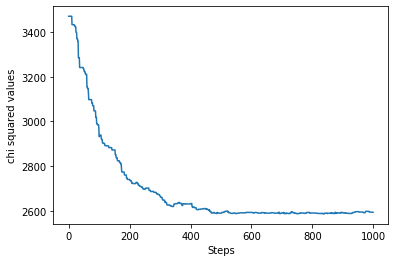

In [93]:
plt.plot(new_chis[:1000])
plt.ylabel('chi squared values')
plt.xlabel('Steps')
print('In this plot we can see that the burn-in time is probably around 500 steps')
print(f'The average chi squared value after burn-in is {np.mean(new_chis[700:])}')

Not only is the chi squared value slightly worse, but it took longer for the chain to converge! I must have done something wrong, but I can't figure out how I'd add a prior otherwise....

I ran the chain longer to compensate, and the plots look like this. 

Text(0, 0.5, 'Primordial tilt ($n_{s}$)')

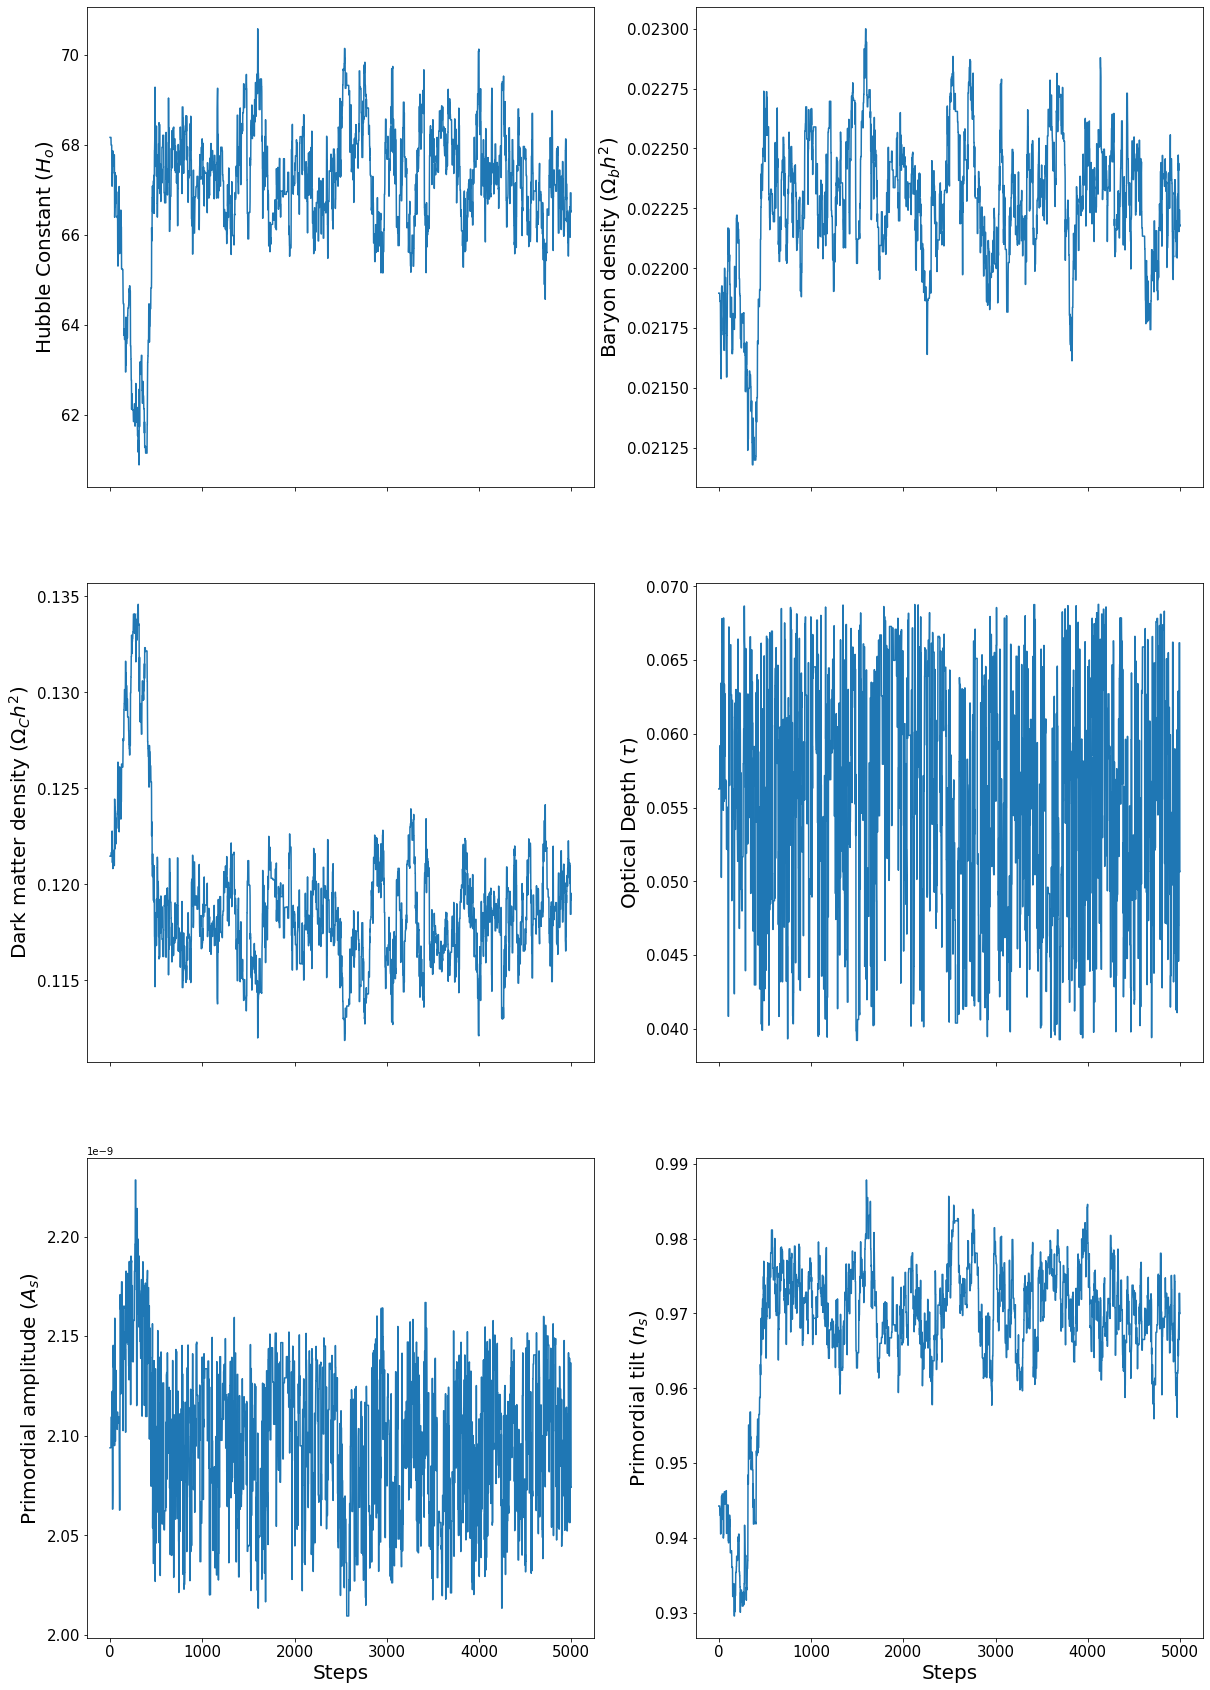

In [94]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,30),sharex=True)

ax1.plot(np.abs(np.transpose(new_params)[0]))
ax1.tick_params(labelsize=15)
ax1.set_ylabel(r'Hubble Constant ($H_{o}$)',fontsize=20)

ax2.plot(np.transpose(new_params)[1])
ax2.tick_params(labelsize=15)
ax2.set_ylabel(r'Baryon density ($\Omega_{b}h^{2}$)',fontsize=20)

ax3.plot(np.transpose(new_params)[2])
ax3.tick_params(labelsize=15)
ax3.set_ylabel(r'Dark matter density ($\Omega_{C}h^{2}$)',fontsize=20)

ax4.plot(np.transpose(new_params)[3])
ax4.tick_params(labelsize=15)
ax4.set_ylabel(r'Optical Depth ($\tau$)',fontsize=20)

ax5.plot(np.transpose(new_params)[4])
ax5.tick_params(labelsize=15)
ax5.set_xlabel('Steps',fontsize=20)
ax5.set_ylabel(r'Primordial amplitude ($A_{s}$)',fontsize=20)

ax6.plot(np.transpose(new_params)[5])
ax6.tick_params(labelsize=15)
ax6.set_xlabel('Steps',fontsize=20)
ax6.set_ylabel(r'Primordial tilt ($n_{s}$)',fontsize=20)

You can see that the chain for the Optical Depth is fantastic! But the others are pretty normal and have an erratic burn in time.

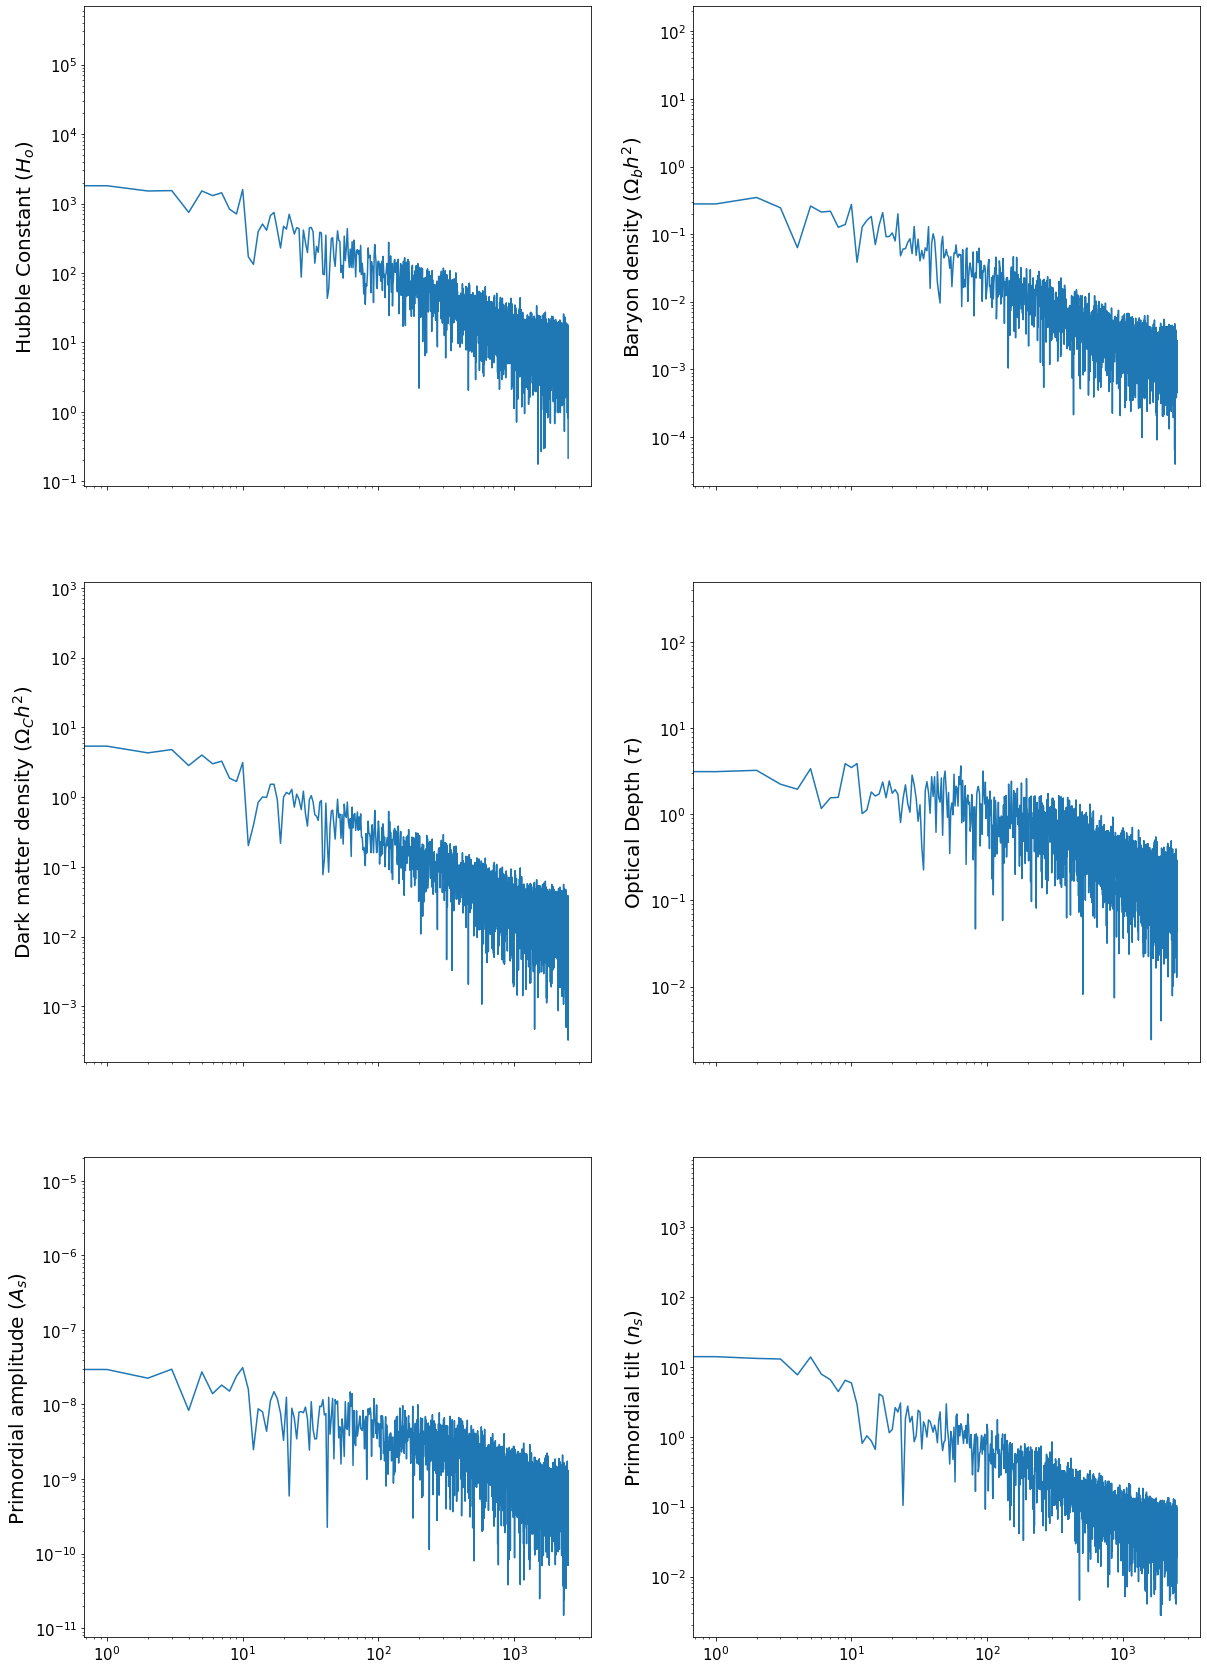

In [96]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,30),sharex=True)


ax1.plot(np.abs(np.fft.rfft(np.transpose(new_params)[0])))
ax1.tick_params(labelsize=15)
ax1.set_ylabel(r'Hubble Constant ($H_{o}$)',fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')


ax2.plot(np.abs(np.fft.rfft(np.transpose(new_params)[1])))
ax2.tick_params(labelsize=15)
ax2.set_ylabel(r'Baryon density ($\Omega_{b}h^{2}$)',fontsize=20)
ax2.set_yscale('log')
ax2.set_xscale('log')

ax3.plot(np.abs(np.fft.rfft(np.transpose(new_params)[2])))
ax3.tick_params(labelsize=15)
ax3.set_ylabel(r'Dark matter density ($\Omega_{C}h^{2}$)',fontsize=20)
ax3.set_yscale('log')
ax3.set_xscale('log')

ax4.plot(np.abs(np.fft.rfft(np.transpose(new_params)[3])))
ax4.tick_params(labelsize=15)
ax4.set_ylabel(r'Optical Depth ($\tau$)',fontsize=20)
ax4.set_yscale('log')
ax4.set_xscale('log')


ax5.plot(np.abs(np.fft.rfft(np.transpose(new_params)[4])))
ax5.tick_params(labelsize=15)
ax5.set_ylabel(r'Primordial amplitude ($A_{s}$)',fontsize=20)
ax5.set_yscale('log')
ax5.set_xscale('log')


ax6.plot(np.abs(np.fft.rfft(np.transpose(new_params)[5])))
ax6.tick_params(labelsize=15)
ax6.set_ylabel(r'Primordial tilt ($n_{s}$)',fontsize=20)
ax6.set_yscale('log')
ax6.set_xscale('log')



These look great! At least all the chains converged :) 